In [319]:
from pyhive import hive
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
import datetime
#Special
import geopandas as gpd #Need to conda install 
from shapely.geometry import Point #Need to conda install 


## Fetch Data

In [429]:
# Connect to database
conn = hive.Connection(host = 'hadoop.rcc.uchicago.edu', 
                       port = 10000, 
                       username = 'bowenliao', 
                       database = 'dmp_yelp_rs')
cursor = conn.cursor()

In [430]:
# Describe business basic data table
query = 'DESCRIBE business_basicdata' #SQL
cursor.execute(query)
cursor.fetchall()

[('business_id', 'string', 'from deserializer'),
 ('name', 'string', 'from deserializer'),
 ('address', 'string', 'from deserializer'),
 ('city', 'string', 'from deserializer'),
 ('state', 'string', 'from deserializer'),
 ('postal_code', 'string', 'from deserializer'),
 ('latitude', 'string', 'from deserializer'),
 ('longitude', 'string', 'from deserializer'),
 ('stars', 'string', 'from deserializer'),
 ('review_count', 'string', 'from deserializer'),
 ('is_open', 'string', 'from deserializer'),
 ('categories', 'string', 'from deserializer')]

In [433]:
# Get sample of business basic data table
query = 'select * from business_basicdata limit 10'
cursor.execute(query)
res = cursor.fetchall()
df = pd.DataFrame(res, columns = [i[0] for i in cursor.description])

In [434]:
# Checking head of data
df.head()

,business_basicdata.business_id,business_basicdata.name,business_basicdata.address,business_basicdata.city,business_basicdata.state,business_basicdata.postal_code,business_basicdata.latitude,business_basicdata.longitude,business_basicdata.stars,business_basicdata.review_count,business_basicdata.is_open,business_basicdata.categories
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.0175444,-105.2833481,4.0,86,1,"Gastropubs, Food, Beer Gardens, Restaurants, B..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.5889058992,-122.5933307507,4.0,126,1,"Salad, Soup, Sandwiches, Delis, Restaurants, C..."
2,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.2513423,-123.101333,3.5,169,1,"Restaurants, Thai"
3,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947006523,-82.99747099999999,4.5,11,1,"Breakfast & Brunch, Restaurants"
4,rYs_1pNB_RMtn5WQh55QDA,Chautauqua General Store,100 Clematis Dr,Boulder,CO,80302,39.9984488,-105.281006,3.5,5,1,"Food, Shopping, Convenience Stores, Souvenir S..."


In [339]:
# Shape of data
df.shape

(63898, 5)

In [350]:
# Get features of interest:
df_geo = df[['business_id']]
df_geo.loc[:,'latitude'] = pd.to_numeric(df.loc[:,'latitude'])
df_geo.loc[:,'longitude'] = pd.to_numeric(df.loc[:,'longitude'])
df_geo['state'] = df['state']
df_geo['city'] = df['city']
df_geo = df_geo.set_index('business_id')

/home/bowenliao/.conda/envs/RyanLiao-env-1.0/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/bowenliao/.conda/envs/RyanLiao-env-1.0/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/bowenliao/.conda/envs/RyanLiao-env-1.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a 

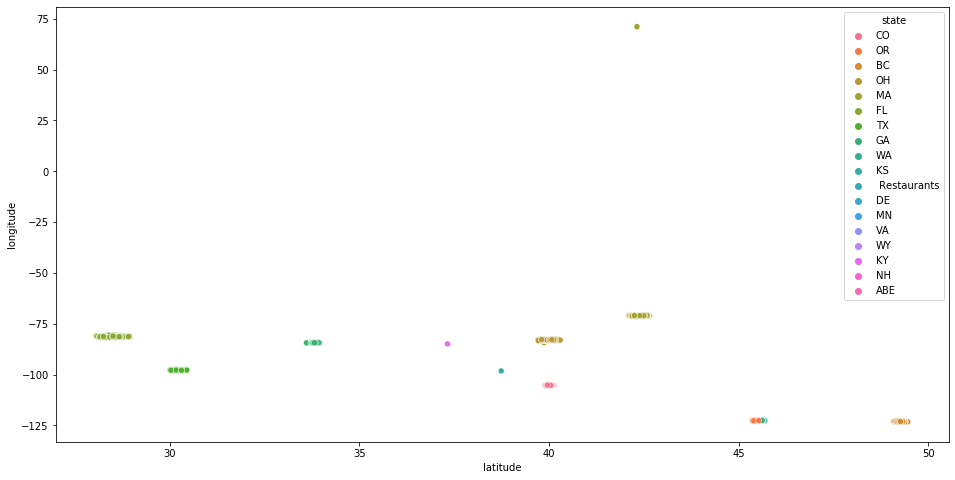

In [351]:
# Plot longitude vs. latitude for businesses, colored by state
plt.figure(figsize=(16,8))
#plt.scatter(list(df_geo['latitude']),list(df_geo['longitude']))
sns.scatterplot(data = df_geo,x='latitude',y='longitude',hue='state')

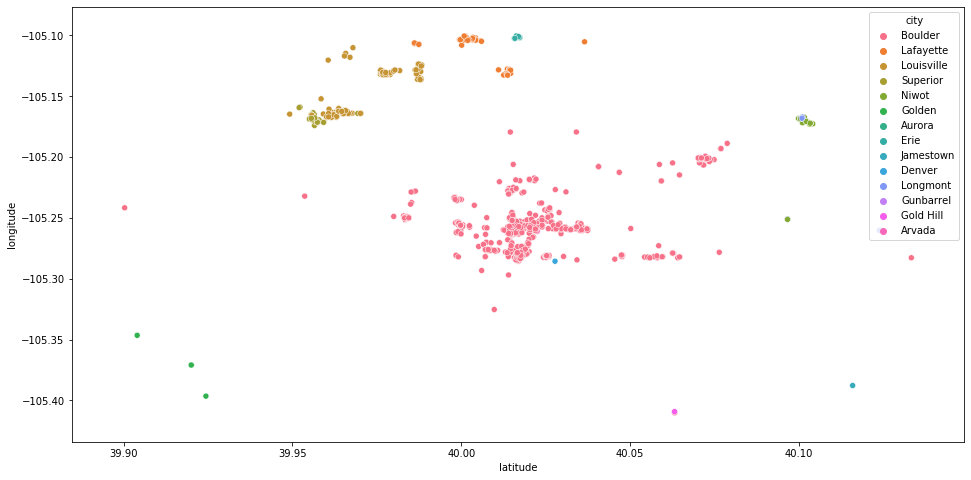

In [352]:
# Plot specifically for Colorado, colored by cities

df_geo_STATE = df_geo.query('state=="CO"')
plt.figure(figsize=(16,8))
#plt.scatter(list(df_geo['latitude']),list(df_geo['longitude']))
sns.scatterplot(data = df_geo_STATE,x='latitude',y='longitude',hue='city')

In [310]:
# Create distance function

from math import sin, cos, sqrt, atan2, radians

def get_distance(point1, point2):
    #Author:Jason Lee
    # Returns distance in KM.
    # Assumes the Earth is spherical
    # Has a ~0.5% difference with the actual distance
    R = 6371
    lat1 = radians(point1[0])  #insert value
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])
    dlon = lon2 - lon1
    dlat = lat2- lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

In [311]:
# Alternate distance function given geo pandas df

def GET_DIST(df_geo,idx,R = 6371):
    """
    n_df:[lat_vec,lon_vec]
    idx:index to compare the rest with
    """
    assert 'latitude' in df_geo,"latitude not in df_geo"
    assert 'longitude' in df_geo,"longitude not in df_geo"
    #Step1:Convert all to radians
    n_df = df_geo.values
    n_df = np.radians(n_df)
    compare_with = np.radians(df_geo.iloc[idx].values)
    
    geo_diff = n_df - compare_with #[dlon,dlat]
    
    a = np.sin(geo_diff[:,0]/2)**2 + np.cos(compare_with[0])*np.cos(n_df[:,0])*np.sin(geo_diff[:,1]/2)**2
    c = 2*np.arctan2(a**0.5,(1-a)**0.5)
    distance = R * c
    return distance

In [312]:
# Calculate distances

%%time
point1 = df_geo.values[0]
out = []
for point2 in df_geo.values:
    out.append(get_distance(point1,point2))
out

CPU times: user 37 ms, sys: 2 ms, total: 39 ms
Wall time: 37 ms


[0.0,
 1538.000046019252,
 1736.992678032943,
 1893.8430319108477,
 2.1326832389876964,
 2861.0783660965403,
 2530.2701148289616,
 2527.9730187447285,
 2533.993165742505,
 2528.4047090255694,
 2852.6557268617435,
 2858.964666899962,
 1732.0325679410664,
 2854.4502000267266,
 1531.6024180119844,
 1284.495838913428,
 1278.3064373635978,
 2500.1865056728593,
 2523.793012643826,
 1719.3592829179079,
 1541.778313021565,
 2524.3624081139806,
 2.7349839704771925,
 2514.7094103586433,
 2843.355891935772,
 2520.261787888401,
 1264.6711721736651,
 1976.1974399870176,
 2519.2420589745843,
 1285.6709849118595,
 2854.1851126602846,
 1549.8851720798875,
 2866.5730710436646,
 1282.4209016353607,
 1975.1307369550932,
 2527.6016368050355,
 1741.3091496013792,
 1542.1951891632282,
 2513.519812722139,
 1535.8872649649531,
 1543.4548052806779,
 1294.6650488782905,
 1544.1244975053432,
 1542.6929797885778,
 1980.5628718120943,
 1541.6546476060134,
 1285.6804265729343,
 1721.8123700402125,
 2851.09905319285

In [313]:
# Calcuate distances from geo pandas df
%%time
GET_DIST(df_geo,0)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.92 ms


array([   0.        , 1538.00004602, 1736.99267803, ..., 2529.3394296 ,
       1554.81458333, 1989.72371608])

In [336]:
# Function for writing list to file

def Write_list(OutFile,lst):
    for i in lst:
        OutFile.write(f'{i},')
    OutFile.write('\n')
    
# Function for storing distances in file
def STORE_Distance(file_name,df_geo):
    assert 'csv' in file_name,'file must be csv'
    with open(file_name, 'w', newline ='') as OutFile:
        write = csv.writer(OutFile)
        write.writerows([df_geo.index])
        for idx in trange(df_geo.shape[0]):
            #Final_Out.append(GET_DIST(df_geo,idx))
            #Write_list(OutFile,)
            write.writerows([GET_DIST(df_geo,idx)])


In [283]:
# Reading back distances
Distance_df = pd.read_csv('DISTANCE.csv')

In [288]:
Distance_df = Distance_df.set_index(df_geo.index)

In [289]:
Distance_df

,6iYb2HFDywm3zjuRg0shjw,tCbdrRPZA0oiIYSmHG3J0w,D4JtQNTI4X3KcbzacDJsMw,jFYIsSb7r1QeESVUnXPHBw,rYs_1pNB_RMtn5WQh55QDA,HPA_qyMEddpAEtFof02ixg,ufCxltuh56FF4-ZFZ6cVhg,GfWJ19Js7wX9rwaHQ7KbGw,dmbbf3AqeG61_QHRZi1M1w,ynTjh_FdhbG5hY69HsEoaA,...,YLL_swwxBVRqVrK__r74WQ,L9kgQsPyTLS6LV2YlkGAkg,ibcZ5jIK2L_hchE5bw6ClA,d7GcIigfMP5d8cbwjcpyxg,jAgewawt7zZnV_OxRmcFBA,ELoaSwFyastXTZJjQnJFbA,bdq65XF1-hTyt6wkrJcKqA,K5IcOOGsrTSw8pOYJM-QrQ,xHnFLg3OXHj3JKozDVYTow,5GvSU3hal8BALDoICil14A
business_id,,,,,,,,,,,,,,,,,,,,,
6iYb2HFDywm3zjuRg0shjw,0.000000,1538.000046,1736.992678,1893.843032,2.132683,2861.078366,2530.270115,2527.973019,2533.993166,2528.404709,...,1985.059351,1739.546442,1916.118651,1281.877422,1537.576787,1271.624739,1977.040393,1282.791215,1738.829116,2839.700137
tCbdrRPZA0oiIYSmHG3J0w,1538.000046,0.000000,409.031144,3258.106204,1539.218080,4066.650773,4061.995178,4060.751848,4065.980596,4060.987318,...,3490.173013,412.447211,3272.045163,2747.281827,5.496785,2739.088576,3480.908361,2748.171590,410.515633,4050.153188
D4JtQNTI4X3KcbzacDJsMw,1736.992678,409.031144,0.000000,3295.373256,1738.565310,4019.848478,4207.780002,4208.960280,4212.318806,4208.727750,...,3606.571564,3.490740,3305.227900,2998.739561,414.254584,2989.519855,3596.275193,2999.647587,1.909315,4005.519750
jFYIsSb7r1QeESVUnXPHBw,1893.843032,3258.106204,3295.373256,0.000000,1893.904185,1044.829254,1280.028011,1296.345997,1286.925665,1293.175887,...,695.890235,3296.590607,33.651913,1714.692581,3259.652067,1705.706450,683.517348,1714.872338,3296.781486,1020.277449
rYs_1pNB_RMtn5WQh55QDA,2.132683,1539.218080,1738.565310,1893.904185,0.000000,2861.506768,2529.258402,2526.942800,2532.976919,2527.378061,...,1984.359085,1741.121067,1916.208436,1280.016917,1538.788515,1269.769992,1976.350979,1280.930726,1740.402185,2840.118196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ELoaSwFyastXTZJjQnJFbA,1271.624739,2739.088576,2989.519855,1705.706450,1269.769992,2730.688662,1595.111841,1582.720616,1595.954988,1585.098650,...,1318.722638,2992.294501,1739.078887,12.392528,2737.541517,0.000000,1319.236184,13.149181,2991.398732,2705.441188
bdq65XF1-hTyt6wkrJcKqA,1977.040393,3480.908361,3596.275193,683.517348,1976.350979,1508.617886,660.610679,670.665379,666.758326,668.668743,...,13.200490,3598.080680,710.276759,1324.418815,3481.367772,1319.236184,0.000000,1324.255225,3597.898982,1483.562964
K5IcOOGsrTSw8pOYJM-QrQ,1282.791215,2748.171590,2999.647587,1714.872338,1280.930726,2738.901456,1594.728168,1582.161217,1595.513229,1584.573400,...,1323.619261,3002.428371,1748.268158,0.914017,2746.605663,13.149181,1324.255225,0.000000,3001.527442,2713.644775


# Try to calculate distance based on State

In [348]:
# Find states of interest, greater than 2 values
states_of_interests = df.state.value_counts()[df.state.value_counts() > 2]
print(states_of_interests)

MA    13499
BC     9563
FL     9529
OR     9366
GA     7477
TX     6978
OH     5318
CO     1133
WA     1025
Name: state, dtype: int64


In [349]:
states_of_interests['MA']

13499

In [368]:
# Query geo pandas df for states of interest, getting latitude and longitude and storing distances in csvs
for state in states_of_interests.keys():
    print(f"Storing for state {state} with {states_of_interests[state]} entries")
    temp_df = df_geo.query(f'state=="{state}"')[['latitude','longitude']]
    STORE_Distance(f'df_distance_{state}.csv',temp_df)

Storing for state MA with 13499 entries


  0%|          | 0/13499 [00:00<?, ?it/s]

Storing for state BC with 9563 entries


  0%|          | 0/9563 [00:00<?, ?it/s]

Storing for state FL with 9529 entries


  0%|          | 0/9529 [00:00<?, ?it/s]

Storing for state OR with 9366 entries


  0%|          | 0/9366 [00:00<?, ?it/s]

Storing for state GA with 7477 entries


  0%|          | 0/7477 [00:00<?, ?it/s]

Storing for state TX with 6978 entries


  0%|          | 0/6978 [00:00<?, ?it/s]

Storing for state OH with 5318 entries


  0%|          | 0/5318 [00:00<?, ?it/s]

Storing for state CO with 1133 entries


  0%|          | 0/1133 [00:00<?, ?it/s]

Storing for state WA with 1025 entries


  0%|          | 0/1025 [00:00<?, ?it/s]

In [367]:
temp_df

,latitude,longitude,state,city
business_id,,,,
HPA_qyMEddpAEtFof02ixg,42.541155,-70.973438,MA,Peabody
hcRxdDg7DYryCxCoI8ySQA,42.338544,-71.106842,MA,Boston
jGennaZUr2MsJyRhijNBfA,42.363442,-71.025781,MA,Boston
iPD8BBvea6YldQZPHzVrSQ,42.342673,-71.084239,MA,Boston
Z2JC3Yrz82kyS86zEVJG5A,42.506935,-71.195854,MA,Burlington
...,...,...,...,...
DXLu9SHnP7eUujx6kcLgmQ,42.493508,-71.100818,MA,Stoneham
s6Hk0G2AWc2wi0tIzfdCSA,42.307142,-71.114307,MA,Jamaica Plain
87f7kR7nTz8WHnmtLM_S6w,42.351408,-71.056867,MA,Boston


# Eng Features of distance

In [375]:
# Getting distances for geo df
res = GET_DIST(df_geo[['latitude','longitude']],0)

In [425]:
# Functions for getting number of businesses within certain radii (km)
def Num_res_within(df_distance_state,Cut_offs = [2,5,10],minus_self = True):
    out = pd.DataFrame()
    if minus_self:
        _a = 1 
    else:
        _a = 0 
    for dist in Cut_offs:
        out[f'within__{dist}_km'] = (df_distance_state < dist).sum() - _a 
    return out

In [394]:
Num_res_within(df_distance_state)

,within__2_km,within__5_km,within__10_km
Mf9io8WkMyGautXuSSfGTg,4,4,4
t-jwGEBsMYlQYxiiqImpIQ,142,142,142
JeU01XydOJZBWAnlqHwP7w,75,75,75
IAxXfqa5dZ89oWLhiNpwhA,135,135,135
Fk6ukR0VYItru6FKSg9HWw,48,48,48
...,...,...,...
q1qMjKO9FmxJgRLwaPLIHA,132,132,132
VkNXTpW6AQ_N9rTihoCBVA,112,112,112
RMcxvvVJI_R9lCL95doK2w,199,199,199
y4vrZcU0EIhX2BENvRtk_w,125,125,125


In [426]:
# Loading and concatenating dfs for number of businesses within radii into 1 df
dist_Comp = pd.DataFrame()
for state in states_of_interests.keys():
    print(f'Calculating for State {state}...')
    start = datetime.datetime.now()
    df_distance_state = pd.read_csv(f'df_distance_{state}.csv')
    end = datetime.datetime.now()
    print(f'Data loaded for State {state} after {end - start}')
    dist_Comp = pd.concat([dist_Comp,Num_res_within(df_distance_state)])

Calculating for State MA...
Data loaded for State MA after 0:02:57.284167
Calculating for State BC...
Data loaded for State BC after 0:01:19.311261
Calculating for State FL...
Data loaded for State FL after 0:01:15.900950
Calculating for State OR...
Data loaded for State OR after 0:01:14.530134
Calculating for State GA...
Data loaded for State GA after 0:00:31.820767
Calculating for State TX...
Data loaded for State TX after 0:00:27.571331
Calculating for State OH...
Data loaded for State OH after 0:00:16.100321
Calculating for State CO...
Data loaded for State CO after 0:00:00.600228
Calculating for State WA...
Data loaded for State WA after 0:00:00.544360


In [424]:
# Saving full results to csv
dist_Comp.to_csv('df_distance_comparison.csv')

# Todos:
- Pre-req: Have rest category
- Quantifiable metric, measuring DIVERSIY (Ryan)

Jason:
- Most freq cat 
- Average Ratings
- Total Conts of review 